# Age & Gender Classifier using Deep CNNs  -

**Dataset : UTKFace**

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

In this notebook, I have used the `aligned and cropped` faces available to train my models. Needless to say, any face input for testing must be cropped and aligned vertically to large extent

In [ ]:
# Mounting the drive so that dataset can be loaded

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Essential libraries
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
# The ImageDataGenerator class has been moved to tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
# print(os.getcwd())

In [ ]:
dataset_folder_name = '/content/drive/MyDrive/UTKFace_DataSet'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [ ]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be
# used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
# fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']


    df = df.dropna()

    return df

In [ ]:

df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and
# visualize data by plotting graphs.

,age,gender,race,file
0,80.0,female,white,/content/drive/MyDrive/UTKFace_DataSet/80_1_0_...
1,80.0,female,white,/content/drive/MyDrive/UTKFace_DataSet/80_1_0_...
2,80.0,female,white,/content/drive/MyDrive/UTKFace_DataSet/80_1_0_...
3,80.0,male,asian,/content/drive/MyDrive/UTKFace_DataSet/80_0_2_...
4,80.0,male,asian,/content/drive/MyDrive/UTKFace_DataSet/80_0_2_...


### Data analysis & visualization (EDA)

After some data preprocessing, let's analyze the data using graphs to get a  better understanding about its distribution





In [ ]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23705 non-null  float64
 1   gender  23705 non-null  object 
 2   race    23705 non-null  object 
 3   file    23705 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.0+ KB


In [ ]:
df.describe()

# Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


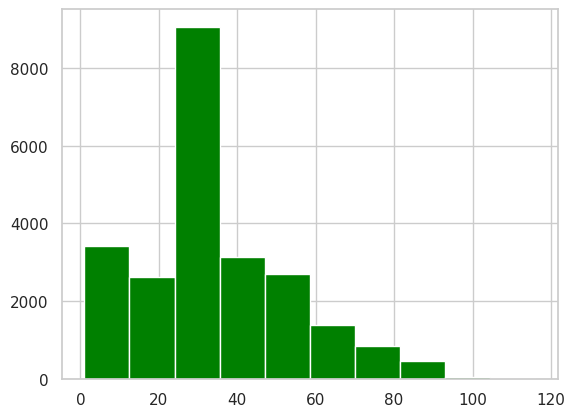

In [ ]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()

# Majority population lies between 20-30 age group. Clearly, the dataset is not very well balanced. So training will
# not be easy & accurate. We don't want to be biased. Try using class weights ?

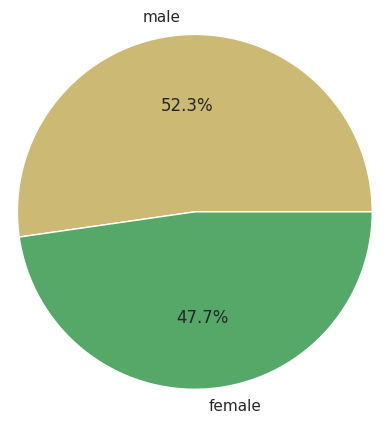

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g']
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

# Uniform distribution to a large extent. Although, males slightly exceed females in numbers.No need to change gender in data.
# Pretty well balanced ! Lets also visualize this on a bar graph (to get better understanding of numbers)

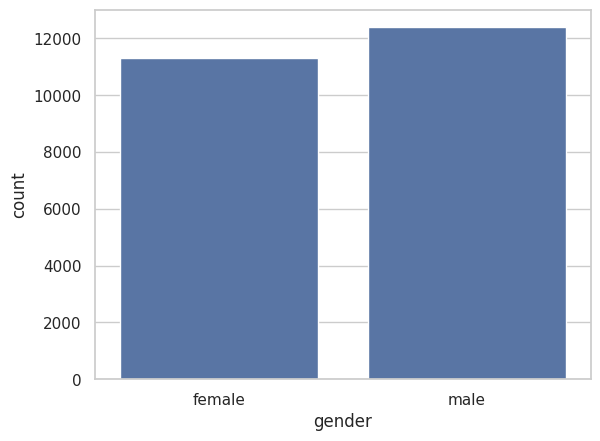

In [ ]:
sns.countplot(x='gender', data=df);

# Males ~ Just over 12k
# Females ~ Just over 11k

In [ ]:
df.groupby(['gender']).mean(numeric_only=True)  # Calculate mean only for numeric columns

,age
gender,
female,30.678186
male,35.695666


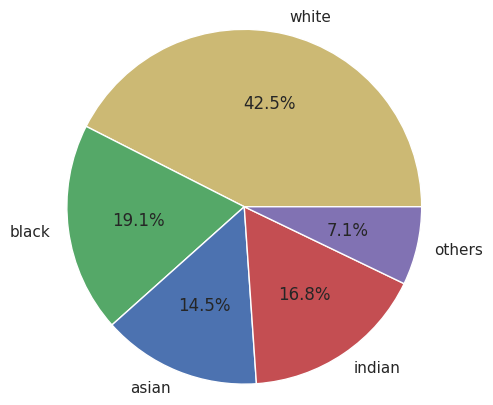

In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m']
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

In [ ]:
# Convert 'age' column to numeric, handling errors
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Calculate the mean age by race
result = df.groupby(['race'])['age'].mean()
print(result)

race
asian     25.867501
black     33.860362
indian    31.532830
others    23.169031
white     37.980949
Name: age, dtype: float64


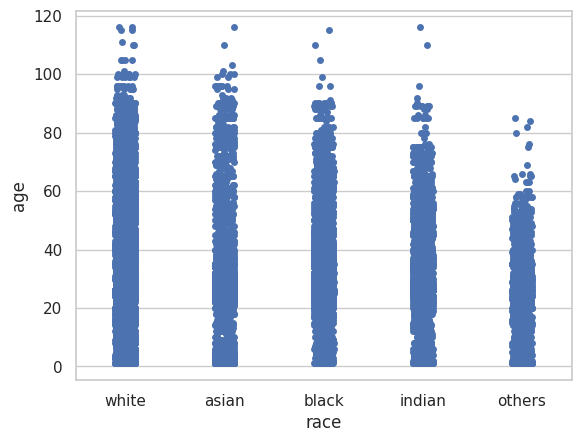

In [ ]:
sns.set(style ="whitegrid")
_ = sns.stripplot(x='race',y='age',data=df)

# Not very useful :( , we only understand that not many elderly ppl (above 60) in others category are present

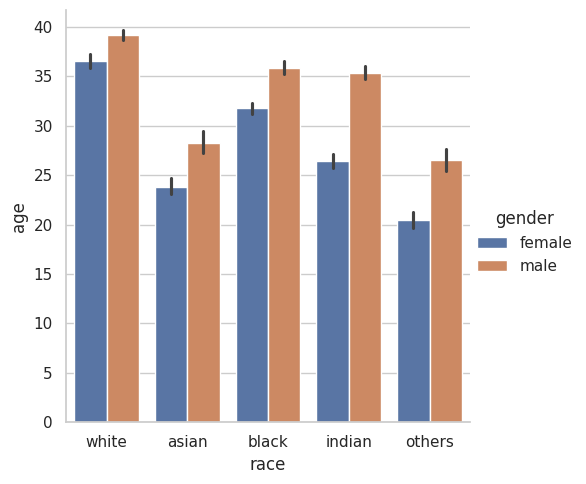

In [ ]:
sns.catplot(x='race', y='age', hue='gender', data=df, kind='bar');

# Gives the mean age of both genders of all races

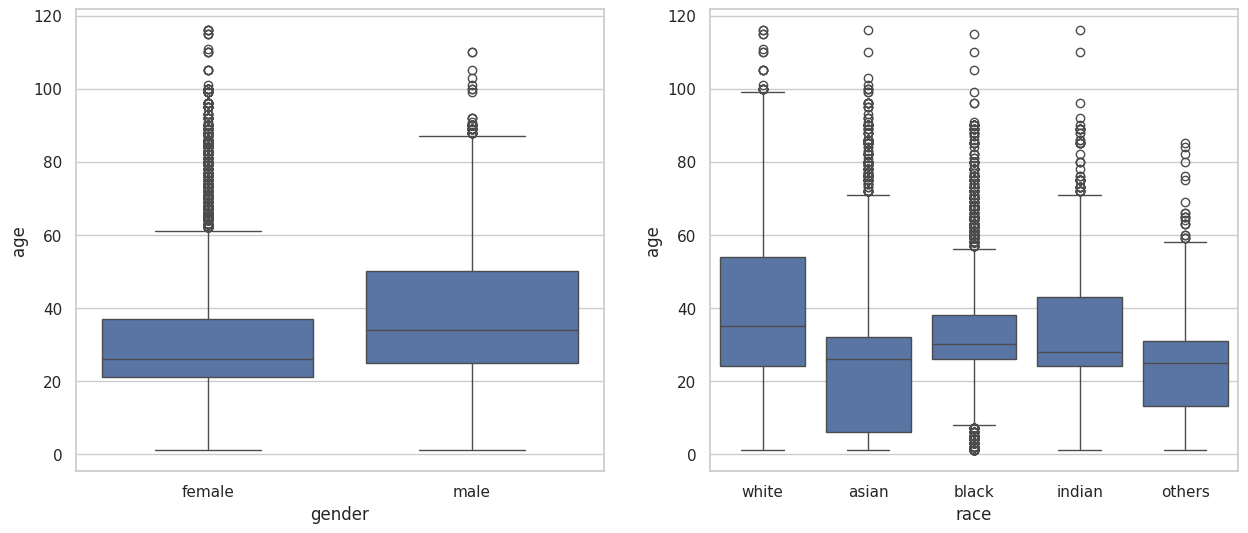

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

In [ ]:
df['age'] = df['age']//25

''' This basically makes 5 divisions in age-groups -
1. 0-24
2. 25-49
3. 50-74
4. 75-99
5. 100-124 '''

' This basically makes 5 divisions in age-groups -\n1. 0-24\n2. 25-49\n3. 50-74\n4. 75-99\n5. 100-124 '

In [ ]:
x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum()

print(x,' ',y,' ',z,' ',a,' ',b, ' ',c)


6903   11815   3988   967   32   0


In [ ]:
df.head()

,age,gender,race,file
0,3.0,female,white,/content/drive/MyDrive/UTKFace_DataSet/80_1_0_...
1,3.0,female,white,/content/drive/MyDrive/UTKFace_DataSet/80_1_0_...
2,3.0,female,white,/content/drive/MyDrive/UTKFace_DataSet/80_1_0_...
3,3.0,male,asian,/content/drive/MyDrive/UTKFace_DataSet/80_0_2_...
4,3.0,male,asian,/content/drive/MyDrive/UTKFace_DataSet/80_0_2_...


## Data Generator
In order to input our data to our Keras multi-output model, we have a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).

In [ ]:
from keras.utils import to_categorical
from PIL import Image as PILImage
import tensorflow as tf

p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx

def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.

    im = PILImage.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0

    return im


def generate_images(image_idx, is_training, batch_size=16):
    """
    Used to generate a batch with images when training/validating our model.
    """
    # Define output signature
    output_signature = (
        tf.TensorSpec(shape=(batch_size, IM_HEIGHT, IM_WIDTH, 3), dtype=tf.float32),  # Images
        (
            tf.TensorSpec(shape=(batch_size, 5), dtype=tf.float32),  # Ages
            tf.TensorSpec(shape=(batch_size, 2), dtype=tf.float32),  # Genders
        )
    )

    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        lambda: generate_images_inner(image_idx, is_training, batch_size),
        output_signature=output_signature
    )

    if is_training:
        dataset = dataset.repeat()  # Repeat indefinitely for training

    return dataset  # Return the dataset instead of the generator


def generate_images_inner(image_idx, is_training, batch_size):
    """
    Helper function to generate image batches.
    """
   # arrays to store our batched data
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]

            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']

            im = preprocess_image(file)

            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            # clip age to be within the valid range for to_categorical
            ages.append(to_categorical(np.clip(age, 0, 4), 5))
            images.append(im)

            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), (np.array(ages), np.array(genders))
                images, ages, genders = [], [], []

        if not is_training:
            break

## Model Architecture

In [ ]:
from keras.models import Model
# The BatchNormalization layer has been moved to keras.layers
from keras.layers import BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, Activation, Dropout
from keras.layers import SpatialDropout2D, Lambda, Dense, Flatten, Input
from keras.regularizers import l2

import tensorflow as tf

def make_default_hidden_layers(inputs):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

def build_gender_branch(inputs):

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)

    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x)

    return x

def build_age_branch(inputs):

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)

    return x


def assemble_model(width, height):

    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, gender_branch], name="face_net")

    return model

model = assemble_model(198, 198)

Convolutional neural networks work on 2 assumptions -

1. Low level features are local
2. What's useful in one place will also be useful in other places.

Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand. In general, smaller filters are considered better than larger filter sizes. Also, usually -

* Number of filters tend to increase with depth of model (more representational capacity is required in the model)

* Size of filters is almost always odd. Like 3x3, 5x5
* Filter size tends to decrease with depth of the model (initial layers have larger receptive fields).

In [ ]:
# picture = "/content/drive/My Drive/classifiers.PNG"
# from IPython.display import Image
# Image(picture, width=350)

# # Model design flowchart

In [ ]:
model.summary()

Model: "face_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 198, 198, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_28       │ (None, 198, 198, 32)   │            155 │ input_layer_2[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 198, 198, 32)   │              0 │ separable_conv2d_28[0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 66, 66, 32)     │              0 │ activation_38[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 66, 66, 32)     │            128 │ max_pooling2d_28[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_29       │ (None, 66, 66, 64)     │          2,400 │ batch_normalization_3… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_35       │ (None, 198, 198, 32)   │            155 │ input_layer_2[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 66, 66, 64)     │              0 │ separable_conv2d_29[0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_48             │ (None, 198, 198, 32)   │              0 │ separable_conv2d_35[0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 33, 33, 64)     │              0 │ activation_39[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_35          │ (None, 66, 66, 32)     │              0 │ activation_48[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 33, 33, 64)     │            256 │ max_pooling2d_29[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 66, 66, 32)     │            128 │ max_pooling2d_35[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 471,197 (1.80 MB)

 Trainable params: 466,077 (1.78 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [ ]:
# # A callback is a set of functions to be applied at given stages of the training procedure.

# import math
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import LearningRateScheduler

# # When training a neural network, the learning rate is often the most important
# # hyperparameter to tune. When training deep neural networks, it is often useful
# # to reduce learning rate as the training progresses.

# # LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

# def step_decay(epoch):
#   initial_lrate = 0.008
#   drop = 0.5
#   epochs_drop = 5.0
#   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#   return lrate

# 	# initial_lrate = 0.002
# 	# drop = 0.5
# 	# epochs_drop = 7.0
# 	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# 	# return lrate

# # Change 'lr' to 'learning_rate'
# opt = Adam(learning_rate=0.0)   # 0.0 here signifies this is not to be used
# lrate = LearningRateScheduler(step_decay)





# model.compile(
#     optimizer=opt,
#     loss={
#         "age_output": "categorical_crossentropy",
#         "gender_output": "categorical_crossentropy",
#     },
#     metrics={"age_output": "accuracy", "gender_output": "accuracy"},
# )

# callbacks_list = [lrate]

# # It is this callback that allows a function to invoke during program execution.

Đoạn code dưới được thêm vào ModelCheckpoint callback

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

# When training a neural network, the learning rate is often the most important
# hyperparameter to tune. When training deep neural networks, it is often useful
# to reduce learning rate as the training progresses.

# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
	initial_lrate = 0.002
	drop = 0.5
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

# Change 'lr' to 'learning_rate'
opt = Adam(learning_rate=0.0)   # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)

# Thêm ModelCheckpoint callback
filepath = "/content/drive/MyDrive/session_3-weights-improvement-{epoch:02}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model.compile(
    optimizer=opt,
    loss={
        "age_output": "categorical_crossentropy",
        "gender_output": "categorical_crossentropy",
    },
    metrics={"age_output": "accuracy", "gender_output": "accuracy"},
)



 Keras does not touch class imbalance issues on its own.  If you aren't going to handle imbalance from the data directly, you should introduce an additional parameter in your loss function that understands the class distribution. In Keras, the param is called `class_weight`

Class weights, ensure that the unevenness in data distribution is sorted out.
Basically, **classes with less numbers are given more weight**, so that model doesn't get biased towards the more prevalent classes.

In [ ]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced' ,np.array([0,1,2,3,4]) ,np.array(df['age']))


# class_weight1 = {'age_output': class_weight}

In [ ]:
from sklearn.utils import class_weight

# Get unique class labels from your target variable
classes = np.unique(df['age'])

# Calculate class weights
class_weight = class_weight.compute_class_weight(
    class_weight='balanced', classes=classes, y=df['age']
)

class_weight1 = {'age_output': class_weight}

### Some key points to remember


*   **ModelCheckpoint** - ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. This is very essential as DL models can take upto days to train. By default - it's NULL.

    By keeping the filename constant throughout training, we ensure that only the best model weights remain in the file uptill the point we have trained.   
To load weights - `model.load_weights(filepath)`

---



*  **Fit function** -  In the latest version of TF - 2.2.0v (released May 2020), the *fit* function has replaced the *fit_generator* function present before.

---


*  **Validation while training** - All the VALIDATION things, in the *fit* function are related to data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data

---

*   **Loss functions** ( `binary_crossentropy` vs `categorical_crossentropy`) -

  -- For `binary_crossentropy`, sigmoid activation, scalar target

  -- For `categorical_crossentropy`, softmax activation, one-hot encoded target

---

*  **LearningRateSchedular Callback** - The LearningRateScheduler callback allows us to define a function to call that takes the epoch number as an argument and returns the learning rate to use in optimizer. When used, the learning rate specified by optimizer is ignored.









In [ ]:
# # # Load the latest saved weights:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/session_1-weights-improvement-03.keras')  ###

In [ ]:
train_gen = generate_images(train_idx, is_training=True, batch_size=32)

# Since, train_idx is too large to fit inside RAM at once, we generate batches of size 32/64 from it (called train_gen))

valid_gen = generate_images(val_idx, is_training=True, batch_size=32)

# Thêm checkpoint vào callbacks_list
callbacks_list = [lrate, checkpoint]

# It is this callback that allows a function to invoke during program execution.


history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                    validation_data=valid_gen, validation_steps=len(val_idx)//32, initial_epoch = 0)    ###



Epoch 4/22
 51/592 ━━━━━━━━━━━━━━━━━━━━ 1:33:17 10s/step - age_output_accuracy: 0.1271 - age_output_loss: 5.4452 - gender_output_accuracy: 0.8752 - gender_output_loss: 0.2678 - loss: 5.9174



---


Clearly, the performance of the model is saturating. I found the reason to be the diminutive learning rate after 45 epochs which becomes 0.0005, that is too low for the model to learn anything. *When the learning rate is too small, training is not only slower, but may become permanently stuck with a high training error.* This is precisely what seems to have happened above.

Hence, we train the model, by **re-establishing the learning rate** to a lower value than initialized before (as model would be now at the trough , looking for the minimum using Adam optimizer). I decided it to be 0.002 and again keep a drop every 12 epochs. Initializing the learning rate higher than 0.002, results in very volatile and fluctuating results, as the model keeps on oscillating about that minimum.

We see that the model has started overfitting. Validation loss for both age and gender is increasing, which a clear sign of overfitting. Hence, stop the training, else the model might lose its generalization ability.

I tried training further, and the accuracy was not able to increase. Hence, I conclude that the model has achieved saturation.

In [ ]:
model.save('/content/drive/My Drive/best_model.keras')         # Saving the above run model. It has performed best till date.

### The short answer to saving and loading -

#### **Saving a Keras Model** -
`model = ...  # Get model (Sequential, Functional Model, or Model subclass)`

`model.save('path/to/location')`

This `save` function saves -


1.   The architecture of the model, allowing to re-create the model.
2.   The weights of the model.
3.   The training configuration (loss, optimizer).
4.   The state of the optimizer, allowing to resume training exactly where you left off.

Calling `save('my_model')` creates a SavedModel folder `my_model`, containing the following - `assets` , `saved_model.pb` &  `variables`. The model architecture, and training configuration (including the optimizer, losses, and metrics) are stored in `saved_model.pb`. The weights are saved in the `variables/` directory.

#### **Loading the model back** -
`model = keras.models.load_model('path/to/location')`




**Chỗ này load vào new_model để chạy thử**

In [ ]:
# Load the latest model
from tensorflow import keras
new_model = keras.models.load_model('/content/drive/MyDrive/session_1-weights-improvement-03.keras')

In [ ]:
# from keras.preprocessing import image
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# Import ImageDataGenerator from the correct location
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/MyDrive/Test/17_0_1_20170110232231513.jpg.chip.jpg"
age_pred, gender_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)
plt.imshow(img)
plt.show()
max=-1
count=0

for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')
